<a href="https://colab.research.google.com/github/mandar33/BI-LSTM-CRF-FC/blob/main/UniLSTM-CRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import numpy as np
import random
import math
from tqdm import tqdm
import os
import re
import io


In [8]:
class dictionary():
    def __init__(self):
        self.word_freq={}
        self.id2word={}
        self.word2id={}
    
    def add_word(self,word):
        if word in self.word_freq:
            self.word_freq[word]+=1
        else:
            self.word_freq[word]=1
        
    def create_mapping(self):
        self.word_freq['[PAD]']=1000001
        self.word_freq['[UNK]']=1000000
        c_unk=0
        dic_items=[]
        for k in self.word_freq.keys():
            if self.word_freq[k]>1 or np.random.uniform()>0.5:
                dic_items.append((k,self.word_freq[k]))
            else:
                c_unk+=1
        ordered_lis=sorted( dic_items, key=lambda x: (-x[1],x[0]))
        assert ordered_lis[0][0]=='[PAD]'
        self.id2word=dict([(i,ordered_lis[i][0]) for i in range(len(ordered_lis))])
        self.word2id=dict([(ordered_lis[i][0],i) for i in range(len(ordered_lis))])
        self.ordered_lis=ordered_lis
        return c_unk

    def get_id(self,word):
        if word in self.word2id:
            return self.word2id[word]
        else:
            return 1
    
    def get_word(self,idx):
        return self.id2word[idx]
    
    def get_len(self):
        return len(self.id2word)

In [9]:
class I2B2DatasetReader(Dataset):
    def __init__(self,data_path,dic_word,dic_char,training=False):
        super(I2B2DatasetReader,self).__init__()
        #read data -> X:[[word,word,word,...],[...],[...]] Y:[[0,1,2,3...],...]
        f=open(data_path,encoding='utf-8')
        X=[[]]
        Y=[[]]

        line=f.readline()
        self.label_map=["O","B-problem","I-problem","B-test","I-test","B-treatment","I-treatment","B-MISC","I-MISC"]
        self.label_num=len(self.label_map)

        while line:
            if line=='\n':
                if len(X[-1])>0:
                    X.append([])
                    Y.append([])
            else:
                word,ner=line.split()
                assert ner in self.label_map
                word=re.sub('\d','0',word)      #replace all the digits with 0, this helps
                X[-1].append(word)
                Y[-1].append(self.label_map.index(ner))
            line=f.readline()
                
        f.close()
        if len(X[-1])==0:
            X=X[:-1]
            Y=Y[:-1]

        self.label=Y
        self.data_num=len(X)

        #get word dictionary
        if training:
            dic_word=dictionary()
            for sentence in X:
                for word in sentence:
                    dic_word.add_word(word)
            dic_word.create_mapping()

        #get word_ids: list of lists
        #encode words str->id
        self.word_ids=[]
        for i in range(len(X)):
            self.word_ids.append(list(map(lambda x:dic_word.get_id(x), X[i])))

        #get character dictionary
        if training:
            dic_char=dictionary()
            for sentence in X:
                text=''.join(sentence)
                for char in text:
                    dic_char.add_word(char)
            dic_char.create_mapping()

        #get char_ids: list of lists of lists
        self.char_ids=[]
        for sentence in X:
            s=[]
            for word in sentence:
                s.append(list(map(lambda x:dic_char.get_id(x), word)))
            self.char_ids.append(s)

        self.dic_word=dic_word
        self.dic_char=dic_char

    def __getitem__(self,index):
        return self.word_ids[index],self.char_ids[index],self.label[index]

    def __len__(self):
        return self.data_num
     



In [10]:
def augment_vocab(dictionary,embedding_path,paths):
            f=open(embedding_path,encoding="utf-8")
            line=f.readline()
            word2emb={}
            while line:
                line=line.split()
                word2emb[line[0]]=torch.from_numpy(np.array(line[1:],dtype=np.str).astype(np.float))
                line=f.readline()

            words=[]
            for data_path in paths:
                f=open(data_path,encoding='utf-8')
                line=f.readline()
                while line:
                    if line=='\n':
                        pass
                    else:
                        word=line.split()[0]
                        words.append(word)
                    line=f.readline()
                f.close()

            train_len=dictionary.get_len()
            for word in words:
                if word not in dictionary.word2id and any([x in word2emb for x in [word,word.lower(),re.sub('\d','0',word.lower())]]):
                    dictionary.word2id[word]=dictionary.get_len()
                    dictionary.id2word[dictionary.get_len()]=word
                    dictionary.ordered_lis.append((word,0))
            num_add=dictionary.get_len()-train_len
            print("original word num: %d  expand num: %d"%(train_len,num_add)) 
            return dictionary,word2emb

def collate_batch(batch):
            #input is a list of tuples
            word_num=list(map(lambda x:len(x[0]),batch))
            max_word_num=max(word_num)
            word_ids=list(map(lambda x:x[0]+[0]*(max_word_num-len(x[0])),batch))
            label_ids=list(map(lambda x:x[2]+[0]*(max_word_num-len(x[2])),batch))

            max_word_length=max(list(map(lambda x:max([len(i) for i in x[1]]),batch)))
            char_ids=[]
            for tuple in batch:
                s=[]
                for word in tuple[1]:
                    s.append(word+[0]*(max_word_length-len(word)))
                s=s+[[0]*max_word_length for i in range((max_word_num-len(s)))]
                char_ids.append(s)

            word_num=torch.LongTensor(word_num)
            word_ids=torch.LongTensor(word_ids)
            char_ids=torch.LongTensor(char_ids)
            label_ids=torch.LongTensor(label_ids)

            return word_num,word_ids,char_ids,label_ids

def forward_alg(observation,transition,word_num):

            def log_sum_exp(matrix,dim):
                maximum,_=matrix.max(dim=dim,keepdim=True)  #to avoid NaN
                return (maximum+torch.log(torch.exp(matrix-maximum).sum(dim=dim,keepdim=True))).squeeze(1)

            observation=observation.transpose(1,2)
            transition=transition.unsqueeze(0).expand(observation.size(0),-1,-1)
            alpha=torch.zeros_like(observation)
            alpha[:,:,0:1]=observation[:,:,0:1]
            for i in range(1,observation.size(2)):
                alpha[:,:,i:i+1]=(observation[:,:,i]+log_sum_exp(alpha[:,:,i-1:i]+transition,dim=1)).unsqueeze(2)
            end_label=alpha[:,10,1:]     #(batch_size, sequence_len)
            return end_label.gather(1,word_num.unsqueeze(1)).squeeze(1)

def list_batch(pred,word_num,word_ids,label_ids,dic_word,label_map):
    pred=pred.tolist()
    word_num=word_num.tolist()
    label_ids=label_ids.tolist()
    word_ids=word_ids.tolist()

    outputs=[]
    for i in range(len(word_num)):
        seq_len=word_num[i]
        prediction=pred[i][:seq_len]
        target=label_ids[i][:seq_len]
        words=word_ids[i][:seq_len]
        prediction=list(map(lambda x: label_map[x], prediction))
        target=list(map(lambda x: label_map[x], target))
        words=list(map(lambda x: dic_word.get_word(x), words))
        for j in range(seq_len):
            outputs.append(' '.join([words[j],target[j],prediction[j]]))
        outputs.append('')
    
    return outputs  

In [11]:
class LSTM_CRF(nn.Module):
    def __init__(self,word2emb,dic_word,dic_char):
        super(LSTM_CRF, self).__init__()
        word_emb_dim=300
        word_lstm_dim=300
        char_emb_dim=25
        char_lstm_dim=25
        label_num=9
        dropout_rate=0.5
            
        word_emb=nn.Embedding(dic_word.get_len(),word_emb_dim,padding_idx=0)
        for i in range(dic_word.get_len()):
            word=dic_word.ordered_lis[i][0]
            if word in word2emb:
                word_emb.weight.data[i]=word2emb[word]
            elif word.lower() in word2emb:
                word_emb.weight.data[i]=word2emb[word.lower()]
            elif re.sub('\d','0',word.lower()) in word2emb:
                word_emb.weight.data[i]=word2emb[re.sub('\d','0',word.lower())]
        #print(word_emb.weight.data[0])


        char_emb=nn.Embedding(dic_char.get_len(),char_emb_dim,padding_idx=0)

        self.char_emb=char_emb
        self.char_lstm=nn.LSTM(char_emb_dim,char_lstm_dim,batch_first=True,num_layers = 1,bidirectional=False)
        self.word_emb=word_emb
        self.dropout=nn.Dropout(dropout_rate)
        self.word_lstm=nn.LSTM(word_emb_dim+char_lstm_dim, word_lstm_dim,batch_first=True,num_layers = 1,bidirectional=False)
        self.fc = nn.Linear(word_lstm_dim, label_num)
       
        
        self.transition=nn.Parameter(torch.full((label_num+2,label_num+2),math.log(1/label_num)))
        
        self.char_lstm_dim=char_lstm_dim
        self.char_emb_dim=char_emb_dim
        self.word_lstm_dim=word_lstm_dim
        self.word_emb_dim=word_emb_dim
        self.label_num=label_num
        
    def get_feature(self,word_num,word_ids,char_ids):
        batch_size=word_ids.size(0)
        sequence_len=word_ids.size(1)
        char_input=self.char_emb(char_ids)
        #print(char_input.size())    #4 dimensional
        char_emb_dim=char_input.size(3)
        word_len=char_input.size(2)
        char_input=char_input.view(batch_size*sequence_len,word_len,char_emb_dim)
        char_hidden,_=self.char_lstm(char_input)    #second output "_" is equal to char_output below
        forward_=char_hidden[:,-1,:self.char_lstm_dim]
        backward_=char_hidden[:,0,self.char_lstm_dim:]
        char_output=torch.cat((forward_,backward_),dim=-1)
        char_output=char_output.view(batch_size,sequence_len,self.char_lstm_dim)

        index=torch.LongTensor(list(range(sequence_len))).cuda().unsqueeze(0).expand(batch_size,sequence_len)
        condition=word_num.unsqueeze(1).expand(batch_size,sequence_len)>index
        mask=torch.where(condition,torch.ones(1,).cuda(),torch.zeros(1,).cuda()).unsqueeze(2)
        char_output*=mask   #to mask all the padding tokens

        word_feature=self.word_emb(word_ids)
        word_feature=torch.cat((word_feature,char_output),dim=-1)
        word_feature=self.dropout(word_feature)
        word_feature,_=self.word_lstm(word_feature)

        word_feature = self.fc(word_feature)
     
        word_feature*=mask
      
        return word_feature,mask
    
    def forward(self,word_num,word_ids,char_ids,label_ids):    
        batch_size=word_ids.size(0)
        sequence_len=word_ids.size(1)
        word_feature,mask=self.get_feature(word_num,word_ids,char_ids)
        
        #compute numerator: the score of target label sequence
        numerator=word_feature.gather(2,label_ids.unsqueeze(2)).squeeze(2).sum(dim=1)
        #print(numerator.size())
        padded_label=torch.cat((torch.full((batch_size,1),9,dtype=torch.long).cuda(), label_ids), dim=1)

        #print(self.transition[(padded_label[:,:-1],padded_label[:,1:])].size()) 
        #a tensor can be indexed by several LongTensors or lists, each of them corresponds with an axis
        trans_score=self.transition[(padded_label[:,:-1],padded_label[:,1:])]   #size(batch_size,sequence_len)
        trans_score*=mask.squeeze(2)
        numerator+=trans_score.sum(dim=1)
        last_label=(padded_label.gather(1,word_num.unsqueeze(1))).squeeze()
        numerator+=self.transition[(last_label,torch.full((batch_size,),10,dtype=torch.long).cuda())]
        
        #prepare observation matrix
        small=-1000
        se_label=torch.full((batch_size,sequence_len,2),small,dtype=torch.float).cuda()*mask
        observation=torch.cat((word_feature,se_label),dim=2)
        observation=torch.cat((torch.full((batch_size,1,self.label_num+2),small,dtype=torch.float).cuda(),
                                observation,
                                torch.full((batch_size,1,self.label_num+2),small,dtype=torch.float).cuda()),dim=1)
        
       
      

        observation[:,0,9]=0
        observation[:,-1,10]=0

        denominator=forward_alg(observation,self.transition,word_num)   #the score of all the label sequences
        loss=-(numerator-denominator)

        return torch.mean(loss)
    
    def decode(self,word_num,word_ids,char_ids):
        batch_size=word_ids.size(0)
        sequence_len=word_ids.size(1)
        word_feature,mask=self.get_feature(word_num,word_ids,char_ids)

        index=torch.LongTensor(list(range(sequence_len))).cuda().unsqueeze(0).expand(batch_size,sequence_len)
        condition=word_num.unsqueeze(1).expand(batch_size,sequence_len)==index
        end_mask=torch.where(condition,torch.ones(1,).cuda(),torch.zeros(1,).cuda()).unsqueeze(2)

        small=-1000
        constrain=torch.full((batch_size,sequence_len,self.label_num+2),small,dtype=torch.float).cuda()*end_mask
        constrain[:,:,10]=0         #tensor "constrain" is used to make sure all the paths finish at [END] state

        se_label=torch.full((batch_size,sequence_len,2),small,dtype=torch.float).cuda()*mask    #correspond with Start and End label
        observation=torch.cat((word_feature,se_label),dim=2)
        observation+=constrain
        observation=torch.cat((torch.full((batch_size,1,self.label_num+2),small,dtype=torch.float).cuda(),
                                observation,
                                torch.full((batch_size,1,self.label_num+2),small,dtype=torch.float).cuda()),dim=1)
        observation[:,0,9]=0
        observation[:,-1,10]=0
        
        #viterbi
        observation=observation.transpose(1,2)
        path=torch.zeros_like(observation).long().cuda()
        transition=self.transition.unsqueeze(0).expand(batch_size,-1,-1)
        z=observation[:,:,0:1]
        for i in range(1,observation.size(2)):
            values,indices=(z+transition).max(dim=1)
            path[:,:,i]=indices
            values+=observation[:,:,i]
            z=values.unsqueeze(2)

        last=path[:,10,-1:]
        pred=last
        for i in range(path.size(2)-2,1,-1):
            last=path[:,:,i].gather(1,last)
            pred=torch.cat((last,pred),dim=1)   
        
        #pred size: batch_size,sequence_len
        #print(pred.size())

        #validation     this step is unnecessary, just make sure there is nothing wrong
        pred_=torch.cat((pred,torch.full((batch_size,1),10,dtype=torch.long).cuda()),dim=1)
        condition=pred_.gather(1,word_num.unsqueeze(1)).squeeze(1)==10
        assert condition.size(0)==(condition.sum().item())
        #print("validation passed")

        return pred


In [14]:
pip install conlleval

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


original word num: 7737  expand num: 1648


100%|██████████| 183/183 [00:07<00:00, 23.27it/s]


epoch 0:  mean loss: 6.5283  f1 score: 34.50  best: 34.50


100%|██████████| 183/183 [00:07<00:00, 23.90it/s]


epoch 1:  mean loss: 3.6972  f1 score: 51.85  best: 51.85


100%|██████████| 183/183 [00:07<00:00, 23.16it/s]


epoch 2:  mean loss: 2.7802  f1 score: 56.41  best: 56.41


100%|██████████| 183/183 [00:08<00:00, 21.51it/s]


epoch 3:  mean loss: 2.2637  f1 score: 60.81  best: 60.81


100%|██████████| 183/183 [00:07<00:00, 23.73it/s]


epoch 4:  mean loss: 1.8887  f1 score: 64.56  best: 64.56


100%|██████████| 183/183 [00:07<00:00, 24.07it/s]


epoch 5:  mean loss: 1.5887  f1 score: 64.59  best: 64.59


100%|██████████| 183/183 [00:07<00:00, 24.13it/s]


epoch 6:  mean loss: 1.3719  f1 score: 66.39  best: 66.39


100%|██████████| 183/183 [00:07<00:00, 23.63it/s]


epoch 7:  mean loss: 1.1773  f1 score: 67.26  best: 67.26


100%|██████████| 183/183 [00:07<00:00, 23.68it/s]


epoch 8:  mean loss: 1.0495  f1 score: 68.24  best: 68.24


100%|██████████| 183/183 [00:07<00:00, 23.97it/s]


epoch 9:  mean loss: 0.9040  f1 score: 70.23  best: 70.23


100%|██████████| 183/183 [00:07<00:00, 23.97it/s]


epoch 10:  mean loss: 0.8022  f1 score: 69.02  best: 70.23


100%|██████████| 183/183 [00:07<00:00, 23.34it/s]


epoch 11:  mean loss: 0.7181  f1 score: 70.00  best: 70.23


100%|██████████| 183/183 [00:07<00:00, 23.90it/s]


epoch 12:  mean loss: 0.6393  f1 score: 68.79  best: 70.23


100%|██████████| 183/183 [00:07<00:00, 24.21it/s]


epoch 13:  mean loss: 0.5755  f1 score: 70.55  best: 70.55


100%|██████████| 183/183 [00:07<00:00, 24.03it/s]


epoch 14:  mean loss: 0.5141  f1 score: 69.89  best: 70.55


100%|██████████| 183/183 [00:07<00:00, 23.78it/s]


epoch 15:  mean loss: 0.4636  f1 score: 70.42  best: 70.55


100%|██████████| 183/183 [00:07<00:00, 24.08it/s]


epoch 16:  mean loss: 0.4170  f1 score: 70.35  best: 70.55


100%|██████████| 183/183 [00:07<00:00, 23.72it/s]


epoch 17:  mean loss: 0.4055  f1 score: 71.18  best: 71.18


100%|██████████| 183/183 [00:07<00:00, 23.45it/s]


epoch 18:  mean loss: 0.3519  f1 score: 70.69  best: 71.18


100%|██████████| 183/183 [00:07<00:00, 23.81it/s]


epoch 19:  mean loss: 0.3283  f1 score: 71.80  best: 71.80


100%|██████████| 183/183 [00:07<00:00, 23.61it/s]


epoch 20:  mean loss: 0.3066  f1 score: 71.18  best: 71.80


100%|██████████| 183/183 [00:07<00:00, 23.62it/s]


epoch 21:  mean loss: 0.2767  f1 score: 71.71  best: 71.80


100%|██████████| 183/183 [00:07<00:00, 23.55it/s]


epoch 22:  mean loss: 0.2601  f1 score: 70.57  best: 71.80


100%|██████████| 183/183 [00:07<00:00, 23.96it/s]


epoch 23:  mean loss: 0.2504  f1 score: 71.03  best: 71.80


100%|██████████| 183/183 [00:07<00:00, 24.13it/s]


epoch 24:  mean loss: 0.2334  f1 score: 71.35  best: 71.80


100%|██████████| 183/183 [00:07<00:00, 23.63it/s]


epoch 25:  mean loss: 0.2135  f1 score: 71.40  best: 71.80


100%|██████████| 183/183 [00:07<00:00, 23.95it/s]


epoch 26:  mean loss: 0.2053  f1 score: 72.08  best: 72.08


100%|██████████| 183/183 [00:07<00:00, 23.76it/s]


epoch 27:  mean loss: 0.2013  f1 score: 72.37  best: 72.37


100%|██████████| 183/183 [00:07<00:00, 23.68it/s]


epoch 28:  mean loss: 0.1800  f1 score: 72.59  best: 72.59


100%|██████████| 183/183 [00:07<00:00, 23.47it/s]


epoch 29:  mean loss: 0.1773  f1 score: 71.42  best: 72.59


100%|██████████| 183/183 [00:07<00:00, 23.64it/s]


epoch 30:  mean loss: 0.1722  f1 score: 71.99  best: 72.59


100%|██████████| 183/183 [00:07<00:00, 24.18it/s]


epoch 31:  mean loss: 0.1525  f1 score: 72.05  best: 72.59


100%|██████████| 183/183 [00:07<00:00, 23.81it/s]


epoch 32:  mean loss: 0.1587  f1 score: 71.47  best: 72.59


100%|██████████| 183/183 [00:07<00:00, 23.69it/s]


epoch 33:  mean loss: 0.1514  f1 score: 71.63  best: 72.59


100%|██████████| 183/183 [00:07<00:00, 23.83it/s]


epoch 34:  mean loss: 0.1417  f1 score: 71.75  best: 72.59


100%|██████████| 183/183 [00:07<00:00, 23.92it/s]


epoch 35:  mean loss: 0.1391  f1 score: 72.13  best: 72.59


100%|██████████| 183/183 [00:07<00:00, 23.48it/s]


epoch 36:  mean loss: 0.1330  f1 score: 72.51  best: 72.59


100%|██████████| 183/183 [00:07<00:00, 23.62it/s]


epoch 37:  mean loss: 0.1273  f1 score: 72.31  best: 72.59


100%|██████████| 183/183 [00:07<00:00, 23.54it/s]


epoch 38:  mean loss: 0.1265  f1 score: 72.87  best: 72.87


100%|██████████| 183/183 [00:07<00:00, 23.69it/s]


epoch 39:  mean loss: 0.1285  f1 score: 72.79  best: 72.87


100%|██████████| 183/183 [00:07<00:00, 23.86it/s]


epoch 40:  mean loss: 0.1282  f1 score: 72.24  best: 72.87


100%|██████████| 183/183 [00:07<00:00, 24.03it/s]


epoch 41:  mean loss: 0.1182  f1 score: 72.86  best: 72.87


100%|██████████| 183/183 [00:07<00:00, 24.22it/s]


epoch 42:  mean loss: 0.1079  f1 score: 72.12  best: 72.87


100%|██████████| 183/183 [00:07<00:00, 23.55it/s]


epoch 43:  mean loss: 0.1039  f1 score: 73.01  best: 73.01


100%|██████████| 183/183 [00:07<00:00, 23.79it/s]


epoch 44:  mean loss: 0.1004  f1 score: 72.19  best: 73.01


100%|██████████| 183/183 [00:07<00:00, 24.05it/s]


epoch 45:  mean loss: 0.1020  f1 score: 72.68  best: 73.01


100%|██████████| 183/183 [00:07<00:00, 23.79it/s]


epoch 46:  mean loss: 0.0977  f1 score: 72.46  best: 73.01


100%|██████████| 183/183 [00:07<00:00, 23.91it/s]


epoch 47:  mean loss: 0.1002  f1 score: 72.29  best: 73.01


100%|██████████| 183/183 [00:07<00:00, 24.17it/s]


epoch 48:  mean loss: 0.0930  f1 score: 72.47  best: 73.01


100%|██████████| 183/183 [00:07<00:00, 24.15it/s]


epoch 49:  mean loss: 0.0925  f1 score: 72.62  best: 73.01


100%|██████████| 183/183 [00:07<00:00, 23.72it/s]


epoch 50:  mean loss: 0.0856  f1 score: 72.79  best: 73.01


100%|██████████| 183/183 [00:07<00:00, 23.98it/s]


epoch 51:  mean loss: 0.0881  f1 score: 72.95  best: 73.01


100%|██████████| 183/183 [00:07<00:00, 23.78it/s]


epoch 52:  mean loss: 0.0887  f1 score: 72.55  best: 73.01


100%|██████████| 183/183 [00:07<00:00, 23.75it/s]


epoch 53:  mean loss: 0.0872  f1 score: 73.04  best: 73.04


100%|██████████| 183/183 [00:07<00:00, 23.87it/s]


epoch 54:  mean loss: 0.0865  f1 score: 72.94  best: 73.04


100%|██████████| 183/183 [00:07<00:00, 23.80it/s]


epoch 55:  mean loss: 0.0875  f1 score: 73.00  best: 73.04


100%|██████████| 183/183 [00:07<00:00, 23.78it/s]


epoch 56:  mean loss: 0.0769  f1 score: 72.59  best: 73.04


100%|██████████| 183/183 [00:07<00:00, 23.46it/s]


epoch 57:  mean loss: 0.0884  f1 score: 73.05  best: 73.05


100%|██████████| 183/183 [00:07<00:00, 23.92it/s]


epoch 58:  mean loss: 0.0852  f1 score: 73.42  best: 73.42


100%|██████████| 183/183 [00:07<00:00, 23.86it/s]


epoch 59:  mean loss: 0.0804  f1 score: 73.69  best: 73.69


100%|██████████| 183/183 [00:07<00:00, 23.83it/s]


epoch 60:  mean loss: 0.0790  f1 score: 73.12  best: 73.69


100%|██████████| 183/183 [00:07<00:00, 23.57it/s]


epoch 61:  mean loss: 0.0767  f1 score: 73.03  best: 73.69


100%|██████████| 183/183 [00:07<00:00, 23.80it/s]


epoch 62:  mean loss: 0.0723  f1 score: 74.20  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.70it/s]


epoch 63:  mean loss: 0.0711  f1 score: 73.46  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.89it/s]


epoch 64:  mean loss: 0.0722  f1 score: 73.64  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.73it/s]


epoch 65:  mean loss: 0.0797  f1 score: 72.78  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.88it/s]


epoch 66:  mean loss: 0.0781  f1 score: 71.66  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.61it/s]


epoch 67:  mean loss: 0.0785  f1 score: 73.15  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.76it/s]


epoch 68:  mean loss: 0.0677  f1 score: 73.94  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.85it/s]


epoch 69:  mean loss: 0.0729  f1 score: 73.58  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 24.15it/s]


epoch 70:  mean loss: 0.0701  f1 score: 73.26  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.88it/s]


epoch 71:  mean loss: 0.0679  f1 score: 73.67  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.52it/s]


epoch 72:  mean loss: 0.0659  f1 score: 73.83  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 24.14it/s]


epoch 73:  mean loss: 0.0632  f1 score: 72.58  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.81it/s]


epoch 74:  mean loss: 0.0649  f1 score: 73.71  best: 74.20


100%|██████████| 183/183 [00:07<00:00, 23.74it/s]


epoch 75:  mean loss: 0.0696  f1 score: 74.24  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.53it/s]


epoch 76:  mean loss: 0.0643  f1 score: 73.52  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 24.00it/s]


epoch 77:  mean loss: 0.0647  f1 score: 74.01  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.78it/s]


epoch 78:  mean loss: 0.0620  f1 score: 73.56  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.79it/s]


epoch 79:  mean loss: 0.0626  f1 score: 74.10  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.56it/s]


epoch 80:  mean loss: 0.0608  f1 score: 74.04  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.50it/s]


epoch 81:  mean loss: 0.0635  f1 score: 73.71  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 24.05it/s]


epoch 82:  mean loss: 0.0588  f1 score: 73.17  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 24.59it/s]


epoch 83:  mean loss: 0.0578  f1 score: 73.89  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.74it/s]


epoch 84:  mean loss: 0.0638  f1 score: 73.21  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.83it/s]


epoch 85:  mean loss: 0.0625  f1 score: 74.16  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.70it/s]


epoch 86:  mean loss: 0.0598  f1 score: 73.90  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.88it/s]


epoch 87:  mean loss: 0.0569  f1 score: 73.51  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.75it/s]


epoch 88:  mean loss: 0.0626  f1 score: 73.75  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 24.09it/s]


epoch 89:  mean loss: 0.0606  f1 score: 74.07  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.80it/s]


epoch 90:  mean loss: 0.0638  f1 score: 73.73  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.94it/s]


epoch 91:  mean loss: 0.0587  f1 score: 73.66  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.95it/s]


epoch 92:  mean loss: 0.0573  f1 score: 73.64  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.65it/s]


epoch 93:  mean loss: 0.0567  f1 score: 73.51  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.60it/s]


epoch 94:  mean loss: 0.0546  f1 score: 74.01  best: 74.24


100%|██████████| 183/183 [00:07<00:00, 23.69it/s]


epoch 95:  mean loss: 0.0531  f1 score: 74.30  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.84it/s]


epoch 96:  mean loss: 0.0558  f1 score: 73.87  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.01it/s]


epoch 97:  mean loss: 0.0576  f1 score: 74.01  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.13it/s]


epoch 98:  mean loss: 0.0536  f1 score: 73.36  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.48it/s]


epoch 99:  mean loss: 0.0564  f1 score: 73.24  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.15it/s]


epoch 100:  mean loss: 0.0492  f1 score: 74.23  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.42it/s]


epoch 101:  mean loss: 0.0503  f1 score: 74.09  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.96it/s]


epoch 102:  mean loss: 0.0562  f1 score: 73.33  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.86it/s]


epoch 103:  mean loss: 0.0556  f1 score: 73.68  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.03it/s]


epoch 104:  mean loss: 0.0533  f1 score: 73.97  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.08it/s]


epoch 105:  mean loss: 0.0537  f1 score: 73.97  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.93it/s]


epoch 106:  mean loss: 0.0513  f1 score: 73.67  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.76it/s]


epoch 107:  mean loss: 0.0554  f1 score: 73.57  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.93it/s]


epoch 108:  mean loss: 0.0496  f1 score: 73.87  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.88it/s]


epoch 109:  mean loss: 0.0489  f1 score: 73.50  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.15it/s]


epoch 110:  mean loss: 0.0511  f1 score: 73.51  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.59it/s]


epoch 111:  mean loss: 0.0519  f1 score: 73.63  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.01it/s]


epoch 112:  mean loss: 0.0467  f1 score: 72.63  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.25it/s]


epoch 113:  mean loss: 0.0527  f1 score: 73.60  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.51it/s]


epoch 114:  mean loss: 0.0486  f1 score: 73.36  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.70it/s]


epoch 115:  mean loss: 0.0488  f1 score: 73.96  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.77it/s]


epoch 116:  mean loss: 0.0481  f1 score: 73.65  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.96it/s]


epoch 117:  mean loss: 0.0463  f1 score: 73.96  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.04it/s]


epoch 118:  mean loss: 0.0493  f1 score: 74.11  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.86it/s]


epoch 119:  mean loss: 0.0444  f1 score: 74.03  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.35it/s]


epoch 120:  mean loss: 0.0462  f1 score: 73.60  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.15it/s]


epoch 121:  mean loss: 0.0489  f1 score: 72.14  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.19it/s]


epoch 122:  mean loss: 0.0483  f1 score: 73.53  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.79it/s]


epoch 123:  mean loss: 0.0457  f1 score: 73.77  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.97it/s]


epoch 124:  mean loss: 0.0452  f1 score: 73.18  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.88it/s]


epoch 125:  mean loss: 0.0476  f1 score: 73.59  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.05it/s]


epoch 126:  mean loss: 0.0442  f1 score: 73.87  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.74it/s]


epoch 127:  mean loss: 0.0469  f1 score: 73.38  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.60it/s]


epoch 128:  mean loss: 0.0467  f1 score: 73.18  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.85it/s]


epoch 129:  mean loss: 0.0499  f1 score: 73.43  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.51it/s]


epoch 130:  mean loss: 0.0492  f1 score: 74.03  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.08it/s]


epoch 131:  mean loss: 0.0416  f1 score: 73.95  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.89it/s]


epoch 132:  mean loss: 0.0431  f1 score: 74.01  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.81it/s]


epoch 133:  mean loss: 0.0448  f1 score: 73.85  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.47it/s]


epoch 134:  mean loss: 0.0428  f1 score: 73.47  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 24.25it/s]


epoch 135:  mean loss: 0.0453  f1 score: 73.29  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.75it/s]


epoch 136:  mean loss: 0.0456  f1 score: 73.90  best: 74.30


100%|██████████| 183/183 [00:07<00:00, 23.49it/s]


epoch 137:  mean loss: 0.0448  f1 score: 74.35  best: 74.35


100%|██████████| 183/183 [00:07<00:00, 23.56it/s]


epoch 138:  mean loss: 0.0395  f1 score: 74.25  best: 74.35


100%|██████████| 183/183 [00:07<00:00, 23.98it/s]


epoch 139:  mean loss: 0.0446  f1 score: 73.77  best: 74.35


100%|██████████| 183/183 [00:07<00:00, 23.77it/s]


epoch 140:  mean loss: 0.0448  f1 score: 74.58  best: 74.58


100%|██████████| 183/183 [00:07<00:00, 24.04it/s]


epoch 141:  mean loss: 0.0394  f1 score: 73.87  best: 74.58


100%|██████████| 183/183 [00:07<00:00, 23.69it/s]


epoch 142:  mean loss: 0.0437  f1 score: 73.50  best: 74.58


100%|██████████| 183/183 [00:07<00:00, 24.07it/s]


epoch 143:  mean loss: 0.0436  f1 score: 73.58  best: 74.58


100%|██████████| 183/183 [00:07<00:00, 23.63it/s]


epoch 144:  mean loss: 0.0440  f1 score: 73.91  best: 74.58


100%|██████████| 183/183 [00:07<00:00, 23.46it/s]


epoch 145:  mean loss: 0.0407  f1 score: 73.91  best: 74.58


100%|██████████| 183/183 [00:07<00:00, 24.26it/s]


epoch 146:  mean loss: 0.0429  f1 score: 73.70  best: 74.58


100%|██████████| 183/183 [00:07<00:00, 23.66it/s]


epoch 147:  mean loss: 0.0445  f1 score: 74.60  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.58it/s]


epoch 148:  mean loss: 0.0452  f1 score: 73.75  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.68it/s]


epoch 149:  mean loss: 0.0423  f1 score: 74.33  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.91it/s]


epoch 150:  mean loss: 0.0405  f1 score: 74.32  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.52it/s]


epoch 151:  mean loss: 0.0383  f1 score: 74.26  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 24.11it/s]


epoch 152:  mean loss: 0.0448  f1 score: 73.98  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.40it/s]


epoch 153:  mean loss: 0.0451  f1 score: 73.95  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 24.48it/s]


epoch 154:  mean loss: 0.0433  f1 score: 73.77  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.94it/s]


epoch 155:  mean loss: 0.0425  f1 score: 74.31  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.80it/s]


epoch 156:  mean loss: 0.0396  f1 score: 74.34  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.68it/s]


epoch 157:  mean loss: 0.0415  f1 score: 74.25  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.74it/s]


epoch 158:  mean loss: 0.0390  f1 score: 74.03  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.68it/s]


epoch 159:  mean loss: 0.0362  f1 score: 74.25  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.93it/s]


epoch 160:  mean loss: 0.0377  f1 score: 73.83  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.71it/s]


epoch 161:  mean loss: 0.0363  f1 score: 74.04  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 23.48it/s]


epoch 162:  mean loss: 0.0373  f1 score: 74.17  best: 74.60


100%|██████████| 183/183 [00:07<00:00, 24.01it/s]


epoch 163:  mean loss: 0.0376  f1 score: 74.65  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.93it/s]


epoch 164:  mean loss: 0.0420  f1 score: 74.35  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.18it/s]


epoch 165:  mean loss: 0.0389  f1 score: 73.89  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.84it/s]


epoch 166:  mean loss: 0.0376  f1 score: 74.17  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 24.17it/s]


epoch 167:  mean loss: 0.0398  f1 score: 73.60  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 24.36it/s]


epoch 168:  mean loss: 0.0417  f1 score: 73.10  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.62it/s]


epoch 169:  mean loss: 0.0379  f1 score: 73.71  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.92it/s]


epoch 170:  mean loss: 0.0403  f1 score: 73.30  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.76it/s]


epoch 171:  mean loss: 0.0420  f1 score: 73.77  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.75it/s]


epoch 172:  mean loss: 0.0407  f1 score: 74.30  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.79it/s]


epoch 173:  mean loss: 0.0391  f1 score: 74.20  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.87it/s]


epoch 174:  mean loss: 0.0376  f1 score: 73.83  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.59it/s]


epoch 175:  mean loss: 0.0348  f1 score: 74.35  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.70it/s]


epoch 176:  mean loss: 0.0358  f1 score: 73.71  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.84it/s]


epoch 177:  mean loss: 0.0365  f1 score: 73.58  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.99it/s]


epoch 178:  mean loss: 0.0377  f1 score: 73.71  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.43it/s]


epoch 179:  mean loss: 0.0372  f1 score: 74.04  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 24.02it/s]


epoch 180:  mean loss: 0.0371  f1 score: 74.24  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.65it/s]


epoch 181:  mean loss: 0.0390  f1 score: 74.47  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.66it/s]


epoch 182:  mean loss: 0.0379  f1 score: 74.10  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.30it/s]


epoch 183:  mean loss: 0.0356  f1 score: 74.26  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.96it/s]


epoch 184:  mean loss: 0.0380  f1 score: 74.41  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.62it/s]


epoch 185:  mean loss: 0.0355  f1 score: 73.86  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.61it/s]


epoch 186:  mean loss: 0.0350  f1 score: 74.12  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.77it/s]


epoch 187:  mean loss: 0.0346  f1 score: 73.92  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.86it/s]


epoch 188:  mean loss: 0.0355  f1 score: 74.31  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.84it/s]


epoch 189:  mean loss: 0.0360  f1 score: 73.82  best: 74.65


100%|██████████| 183/183 [00:07<00:00, 23.60it/s]


epoch 190:  mean loss: 0.0346  f1 score: 74.69  best: 74.69


100%|██████████| 183/183 [00:07<00:00, 23.98it/s]


epoch 191:  mean loss: 0.0351  f1 score: 74.02  best: 74.69


100%|██████████| 183/183 [00:07<00:00, 23.72it/s]


epoch 192:  mean loss: 0.0343  f1 score: 73.78  best: 74.69


100%|██████████| 183/183 [00:07<00:00, 23.53it/s]


epoch 193:  mean loss: 0.0334  f1 score: 73.89  best: 74.69


100%|██████████| 183/183 [00:07<00:00, 23.87it/s]


epoch 194:  mean loss: 0.0359  f1 score: 72.91  best: 74.69


100%|██████████| 183/183 [00:07<00:00, 23.89it/s]


epoch 195:  mean loss: 0.0341  f1 score: 73.98  best: 74.69


100%|██████████| 183/183 [00:07<00:00, 23.99it/s]


epoch 196:  mean loss: 0.0353  f1 score: 73.33  best: 74.69


100%|██████████| 183/183 [00:07<00:00, 23.79it/s]


epoch 197:  mean loss: 0.0326  f1 score: 73.91  best: 74.69


100%|██████████| 183/183 [00:07<00:00, 23.84it/s]


epoch 198:  mean loss: 0.0364  f1 score: 73.18  best: 74.69


100%|██████████| 183/183 [00:07<00:00, 24.32it/s]


epoch 199:  mean loss: 0.0343  f1 score: 73.71  best: 74.69


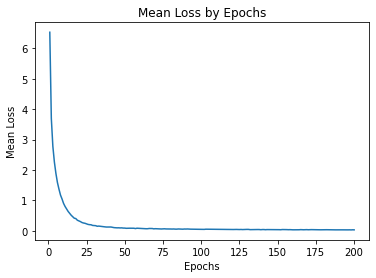

In [16]:
import re


import matplotlib.pyplot as plt

def my_plot(epochs, datalist):
    plt.plot(epochs, datalist)
    # Add title and axis names
    plt.title('Mean Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Loss') 
    #legend = plt.legend(loc='upper right')
    plt.show()



BATCH_SIZE=64
LR=0.001
CLIP=5.
num_epochs = 200
train_dataset=I2B2DatasetReader('./datafiles/train.txt',dictionary(),dictionary(),training=True)
train_dataset.dic_word,word2emb=augment_vocab(train_dataset.dic_word,"datafiles/glove.6B.300d.txt",['./datafiles/dev.txt','./datafiles/test.txt'])
dev_dataset=I2B2DatasetReader('./datafiles/dev.txt',train_dataset.dic_word,train_dataset.dic_char)
test_dataset=I2B2DatasetReader('./datafiles/test.txt',train_dataset.dic_word,train_dataset.dic_char)

train_loader=DataLoader(train_dataset,BATCH_SIZE,shuffle=True,num_workers=2,collate_fn=collate_batch)
dev_loader=DataLoader(dev_dataset,BATCH_SIZE,shuffle=False,num_workers=2,collate_fn=collate_batch)
test_loader=DataLoader(test_dataset,BATCH_SIZE,shuffle=False,num_workers=2,collate_fn=collate_batch)


model = LSTM_CRF(word2emb,train_dataset.dic_word,train_dataset.dic_char).cuda()
optimizer=torch.optim.Adam(model.parameters(),LR)
precision_list = []
accuracy_list = []
recall_list = []
best_score=0
best_f1score_validation = 0
loss_vals=  []
loss_vals_validation =  []
for epoch in range(num_epochs):
    model.train()
    epoch_loss=[]
    pbar=tqdm(total=len(train_loader))
    for i,(word_num,word_ids,char_ids,label_ids) in enumerate(train_loader):
        loss=model(word_num.cuda(),word_ids.cuda(),char_ids.cuda(),label_ids.cuda())
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(lstm_crf.parameters(),CLIP)
        optimizer.step()
        epoch_loss.append(loss.item())
        pbar.update(1)
    pbar.close()
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    mean_loss=torch.mean(torch.tensor(epoch_loss)).item()
   

    model.eval()
    f1_score=0

    
    #for loader in (test_loader):
    testloader=test_loader

    outputs=[]
    for i,(word_num,word_ids,char_ids,label_ids) in enumerate(testloader):
        word_num,word_ids,char_ids,label_ids=word_num.cuda(),word_ids.cuda(),char_ids.cuda(),label_ids.cuda()
        pred=model.decode(word_num,word_ids,char_ids)
        outputs+=list_batch(pred,word_num,word_ids,label_ids, train_dataset.dic_word, train_dataset.label_map)

    f=open('outputs.txt','w',encoding='utf-8')
    f.write('\n'.join(outputs))
    f.close()
    
    os.system("python -m conlleval outputs.txt > results")
    #os.system("./conlleval < outputs.txt > results")
    f=open('results','r',encoding='utf-8')
    
    elems = re.split('[:;]+', f.readlines()[1])
    f1_score=float(elems[7])
    # recall_list.append(elems[5])
    # precision_list.append(elems[3])
    # accuracy_list.append(elems[1])
    f.close()
    best_score=max(best_score,f1_score)
    #print('epoch %d:  mean accuracy: %.4f  mean precision: %.2f  mean recall: %.2f'%(epoch,mean_accuracy,mean_precision,mean_recall))

    print('epoch %d:  mean loss: %.4f  f1 score: %.2f  best: %.2f'%(epoch,mean_loss,f1_score,best_score))

my_plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)  